In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

In [2]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.use('TkAgg')

C:\Users\tetyana.lookutova\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Graph analysis

In [9]:
import networkx as nx

In [10]:
g = nx.Graph()
folder = "--PUT FOLDER PATH HERE--"
full_authbook_name = "associated_users_full_credit-v1.xlsx"
full_authbook = pd.read_excel(folder + full_authbook_name)

In [12]:
full_authbook.columns

Index(['branch_number', 'client_number', 'client_type', 'incorp_date',
       'account_source', 'account_number', 'created_user', 'date_of_opening',
       'credited_amount', 'residual_amount', 'balance',
       'performance_indicator', 'non_serviced', 'auth_user'],
      dtype='object')

In [13]:
full_authbook1 = full_authbook #[full_authbook.performance_indicator.isin([3,4,5])]

In [14]:
full_authbook2 = full_authbook1.loc[full_authbook1.account_source == 'LOAN'].copy()



In [15]:
full_authbook_cr = full_authbook2.dropna(subset=['auth_user','created_user'])

In [16]:
# for nice display - change user names 
full_authbook_cr.auth_user = full_authbook_cr.apply(lambda L: L.auth_user.strip(' ').replace('U', 'loc'), axis=1);


In [17]:
full_authbook_cr.created_user = full_authbook_cr.apply(lambda L: L.created_user.strip(' ').replace('U', 'loc'), axis=1);

In [18]:
full_authbook_cr.head(1)

,branch_number,client_number,client_type,incorp_date,account_source,account_number,created_user,date_of_opening,credited_amount,residual_amount,balance,performance_indicator,non_serviced,auth_user
11,1.0,782679,P,0,LOAN,78267972001,loc9108,20041220,-2300000.0,0.0,-545466.12,N,NaN,loc0057


In [22]:
g=nx.from_pandas_dataframe(full_authbook_cr, 'auth_user', 'created_user', ['performance_indicator', 'residual_amount'])

In [ ]:
# create performance indicator based on the performance indicator in the data, loan service history, 

In [23]:
full_authbook_cr['performance_indicator_int'] = full_authbook_cr.apply(lambda row: 6 if row.performance_indicator == 'E' else (0 if row.performance_indicator == 'N' else int(row.performance_indicator)), axis=1)

In [25]:
full_authbook_cr.performance_indicator_int.unique()

array([0, 6, 1, 4, 2, 3, 5], dtype=int64)

In [26]:
# 1 performance indicator
full_authbook_cr['pi'] = 0
full_authbook_cr.loc[full_authbook_cr['performance_indicator_int'].isin([3]),['pi']] =  1
full_authbook_cr.loc[full_authbook_cr['performance_indicator_int'].isin([4]),['pi']] =  2
full_authbook_cr.loc[full_authbook_cr['performance_indicator_int'].isin([5]),['pi']] =  3
full_authbook_cr.loc[full_authbook_cr['performance_indicator_int'].isin([6]),['pi']] =  1
pd.to_numeric(full_authbook_cr['pi'], errors='coerce');

In [27]:
# 2. residual closed indicator  is already incorporated in previous performance indicator = 6
# 3. less than 4 months indicator for company incorporation
full_authbook_cr['less4months'] = np.where(full_authbook_cr.date_of_opening - full_authbook_cr.incorp_date < 120, 1, 0)

In [128]:
# never serviced is already calculated

In [129]:
# 4. balance > credit indicator

In [28]:
full_authbook_cr['delayed_pay'] = np.where(full_authbook_cr.balance < full_authbook_cr.credited_amount , 1,0)

In [29]:
full_authbook_cr['suspiciousness'] = 0

In [30]:
full_authbook_cr['suspiciousness'] = np.where(full_authbook_cr['non_serviced'] == 1, 1, 0) + full_authbook_cr['pi'] +  full_authbook_cr['less4months'] + full_authbook_cr['delayed_pay'] 

In [32]:
# Get 5 levels of suspiciousness indicator

full_authbook_cr['suspiciousness'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

## Plotting

In [33]:
#add weights and colors
result = full_authbook_cr.groupby(['auth_user', 'created_user'], as_index=False).agg({'suspiciousness':['mean'],'account_number':['count'] })

In [34]:
result.columns = ['authorization_user', 'credit_user','avg_performance','count']
result;

In [35]:
G=nx.Graph()
for d in result[['authorization_user','credit_user','avg_performance', 'count']].values:
    G.add_edge(d[0] ,d[1] ,color= ('forestgreen' if d[2] == 0 else ( 'darkslateblue' if d[2] < np.percentile(result.avg_performance,25) else ('gold' if d[2] < np.percentile(result.avg_performance, 50) else ('darkorange' if  d[2] < np.percentile(result.avg_performance, 75) else 'indianred')))), weight = d[3] )  
    #G.add_edge(d[0] ,d[1] ,color= ('forestgreen' if d[2] == 0 else ( 'forestgreen' if d[2] < np.percentile(result.avg_performance,25) else ('forestgreen' if np.percentile(result.avg_performance, 25) < d[2] < np.percentile(result.avg_performance, 50) else ('darkorange' if  d[2] < np.percentile(result.avg_performance, 75) else 'forestgreen')))), weight = d[3] )  

In [36]:
import collections


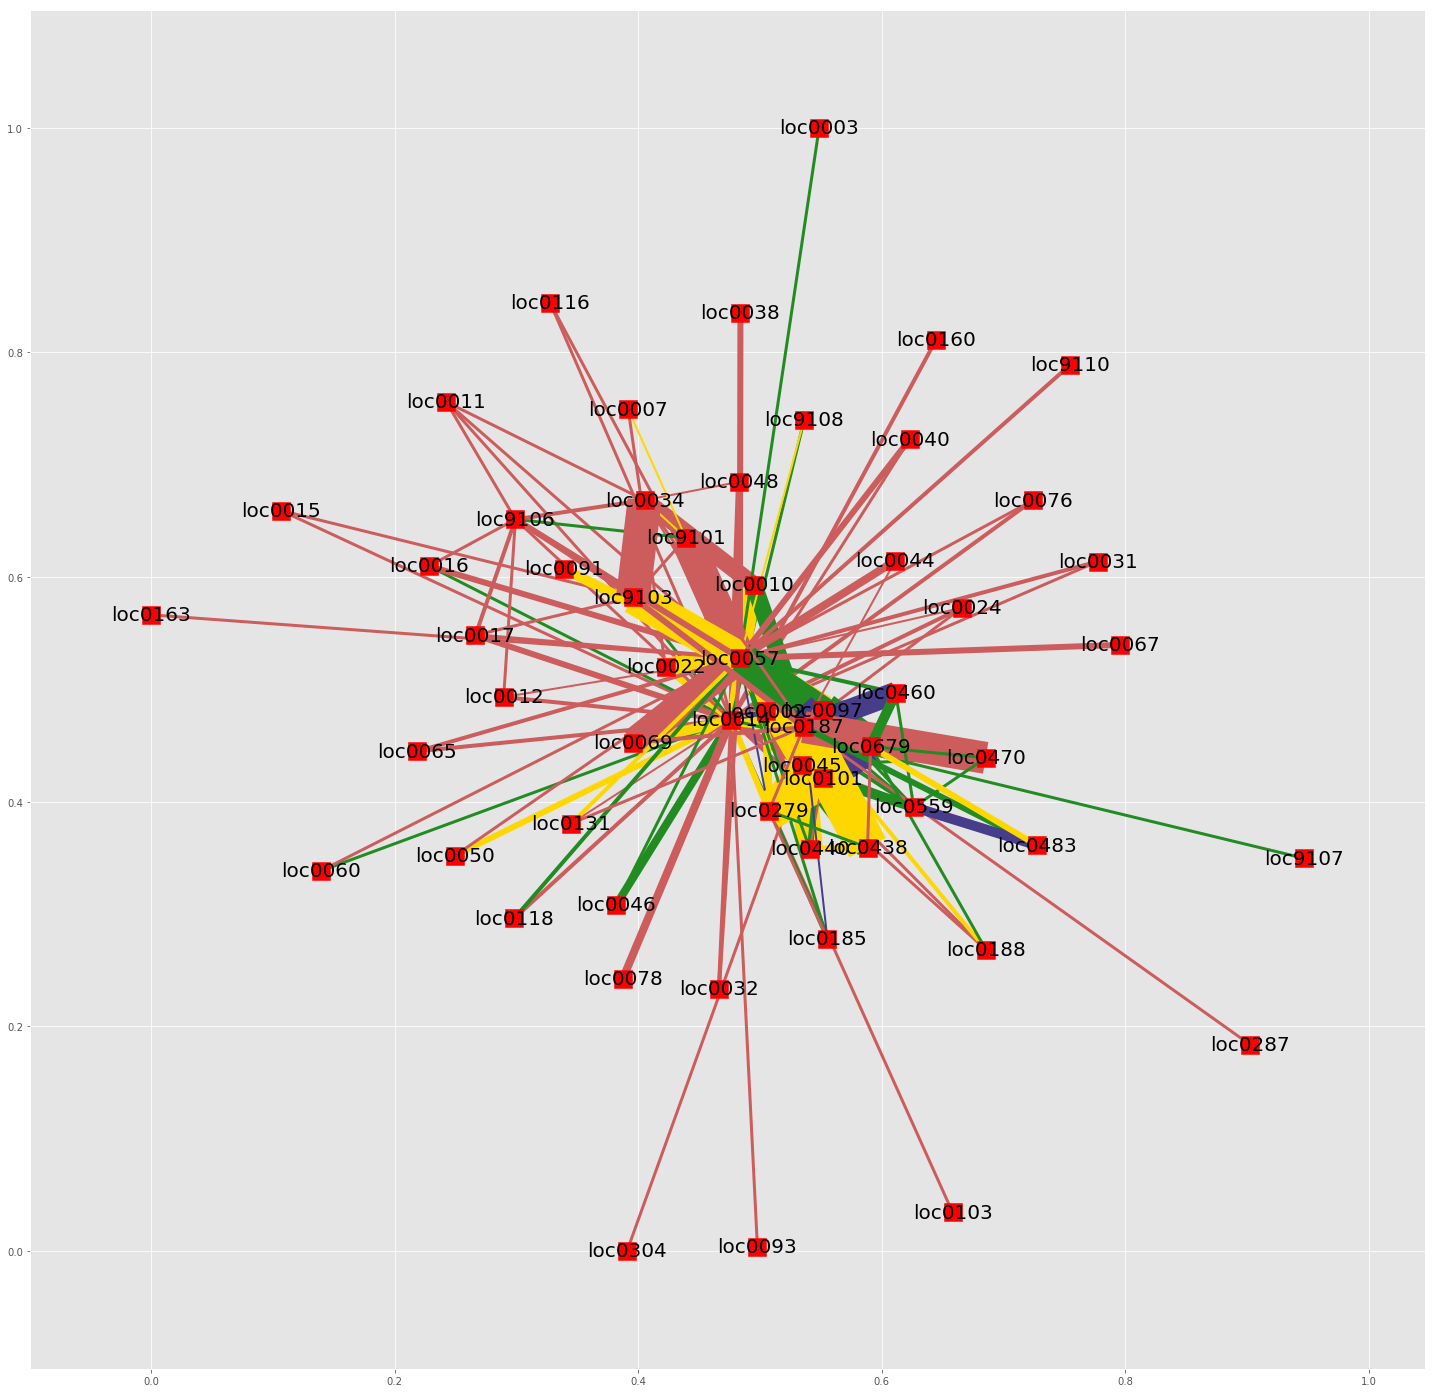

In [37]:
plt.figure(figsize=(25,25))

pos = nx.spring_layout(G, iterations = 200)
#pos = nx.circular_layout(G)
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

x=collections.OrderedDict()
new_ind = 1
for w in weights:
    if not w in x:
        x[w] = new_ind
        new_ind += 1
for i in range(0, len(weights)):
    weights[i] = (x[weights[i]])        

nx.draw_networkx(G,pos, edges = edges, edge_color = colors, width = weights, font_size=20, node_shape='s')
#edge_labels=nx.draw_networkx_edge_labels(G,pos) # 7 - yellow, 6 - green, 5 - blue, 4 - purple